<a href="https://colab.research.google.com/github/Smartsie/Playground/blob/master/Hands_on_Machine_Learning_Ex_1_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px

In [4]:
!pip install shap

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509243 sha256=01711e643cc5136095d1b0e0b68ede18945b9a12b1282b659231114b3c481227
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
from yellowbrick.regressor import ResidualsPlot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [3]:
!pip install 'umap-learn==0.3.10'
!pip install hdbscan

     |████████████████████████████████| 40 kB 5.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38883 sha256=2cf3f9a9e04da34d4a179e485456c0f2d84be47f4118b3f5146ebf77e5d7be49
  Stored in directory: /root/.cache/pip/wheels/ea/d0/8f/9e64bfc5ed0645f89b639196bef92daf5c704285133efce12f
Successfully built umap-learn
     |████████████████████████████████| 6.4 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311903 sha256=7b88c206efeac00702e72fae8e9ab076db6ebc8e67f599489733abf941c969b3
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [2]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path=os.path.join(housing_path,"housing.tgz")
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path=os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing=load_housing_data()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [7]:
housing['income_cat']=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],
                             labels=[1,2,3,4,5])

In [8]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)  
for train_index,test_index in split.split(housing,housing['income_cat']):
  strat_train_set=housing.loc[train_index]
  strat_test_set=housing.loc[test_index]

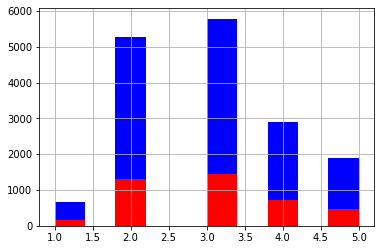

In [9]:
strat_train_set['income_cat'].hist(color='blue')
strat_test_set['income_cat'].hist(color='red')

In [10]:
for set_ in (strat_train_set,strat_test_set):
  set_.drop(['income_cat'],axis=1,inplace=True)

In [17]:
housing=strat_train_set.copy()

In [18]:
px.scatter_mapbox(housing,lat='latitude',lon='longitude',mapbox_style='open-street-map',size='population',color='median_house_value',opacity=0.4,width=800, height=600)

In [11]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set['median_house_value']

In [16]:
housing_num=housing.drop('ocean_proximity',axis=1)
housing_cat=housing[['ocean_proximity']]

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
rooms_ix,bedrooms_ix,population_ix, households_ix=3,4,5,6

In [14]:
class CombinedAttritubesAdder(BaseEstimator,TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room=add_bedrooms_per_room
  def fit(self,X,y=None):
    return self # nothing else to do
  def transform(self,X):
    rooms_per_household=X[:,rooms_ix]/X[:,households_ix]
    population_per_household=X[:,population_ix]/X[:,households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]


In [15]:
#attr_adder=CombinedAttritubesAdder(add_bedrooms_per_room=False)

In [16]:
#housing_extra_attribs=attr_adder.transform(housing.values)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
num_pipeline=Pipeline([
                       ('imputer',SimpleImputer(strategy='median')),
                       ('attribs_adder',CombinedAttritubesAdder()),
                       ('std_scaler',StandardScaler()),
])

In [19]:
housing_num=housing.drop('ocean_proximity',axis=1)
#housing_num_tr=num_pipeline.fit_transform(housing_num)

In [20]:
from sklearn.compose import ColumnTransformer
num_attribs=list(housing_num) # extracts columns names
cat_attribs=['ocean_proximity']
full_pipeline=ColumnTransformer([
                                 ("num",num_pipeline,num_attribs),
                                 ("cat",OneHotEncoder(),cat_attribs),
])
housing_prepared=full_pipeline.fit_transform(housing)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [22]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model, housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

NameError: ignored

In [78]:
model=Pipeline([
                ('full',full_pipeline),
                ('reg',DecisionTreeRegressor())
                ])

In [80]:
#model=DecisionTreeRegressor()
#model=RandomForestRegressor()
#model=KNeighborsRegressor(n_neighbors=10)
#model=LinearRegression()

model.fit(housing,housing_labels)

Pipeline(memory=None,
         steps=[('full',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                     

In [ ]:
print(scores)

In [ ]:
import shap
#shap_values = shap.TreeExplainer(model).shap_values(housing_prepared)
#shap_values = shap.Explainer(model.predict).shap_values(housing)
shap_values = shap.explainers.Tree(model).shap_values(housing_prepared)

#shap.summary_plot(shap_values, housing_prepared, plot_type="bar")

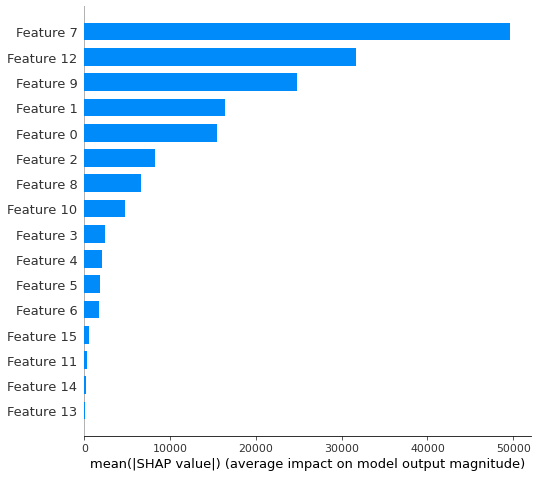

In [46]:
shap.summary_plot(shap_values, housing_prepared, plot_type="bar")

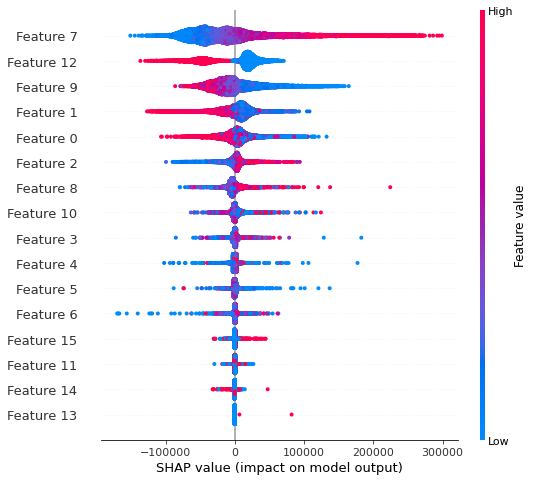

In [47]:
shap.summary_plot(shap_values, housing_prepared)

In [51]:
housing_prepared.shape

(16512, 16)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid=[
            {'n_estimators':[3,10,30],
             'max_features':[2,4,6,8]},
            {'bootstrap':[False],'n_estimators':[3,10],
             'max_features':[2,3,4]},
]

In [ ]:
forest_reg=RandomForestRegressor()

In [ ]:
grid_search=GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

In [ ]:
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
final_model=grid_search.best_estimator_

In [59]:
final_model=model

In [60]:
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set['median_house_value']
X_test_prepared=full_pipeline.transform(X_test)

In [61]:
final_prediction=final_model.predict(X_test_prepared)

In [62]:
final_mse=mean_squared_error(y_test, final_prediction)
final_rmse=np.sqrt(final_mse)

In [63]:
print(final_rmse)

58843.44065555195


AttributeError: ignored

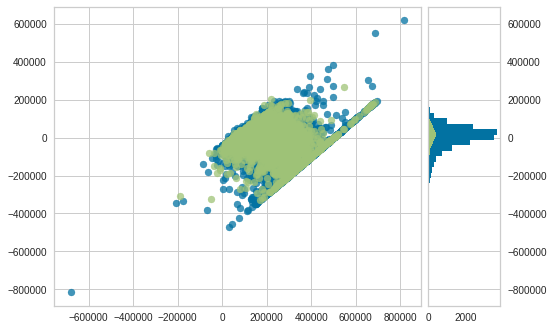

In [72]:
visualizer = ResidualsPlot(model)

visualizer.fit(housing_prepared,housing_labels)  # Fit the training data to the visualizer
visualizer.score(X_test_prepared, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
# Feature importance analysis
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [24]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 16 kB/s 


In [52]:
import shap

In [34]:
from catboost import CatBoostRegressor, Pool

In [42]:
categorical_features=['ocean_proximity']

In [43]:
model=CatBoostRegressor(cat_features=categorical_features)

In [44]:
model.fit(housing,housing_labels)

Learning rate set to 0.063766
0:	learn: 111520.9801743	total: 11.5ms	remaining: 11.4s
1:	learn: 107581.2905218	total: 21ms	remaining: 10.5s
2:	learn: 104029.2112324	total: 30.3ms	remaining: 10.1s
3:	learn: 100628.1717607	total: 39.9ms	remaining: 9.94s
4:	learn: 97566.5037043	total: 48.5ms	remaining: 9.66s
5:	learn: 95001.9806241	total: 56.9ms	remaining: 9.43s
6:	learn: 92603.6419498	total: 66.6ms	remaining: 9.45s
7:	learn: 90197.7168216	total: 75.8ms	remaining: 9.4s
8:	learn: 88101.9398526	total: 85ms	remaining: 9.36s
9:	learn: 86253.5803800	total: 94.1ms	remaining: 9.32s
10:	learn: 84528.4086647	total: 103ms	remaining: 9.26s
11:	learn: 82842.7908459	total: 112ms	remaining: 9.24s
12:	learn: 81384.6626007	total: 121ms	remaining: 9.21s
13:	learn: 79916.3526017	total: 130ms	remaining: 9.17s
14:	learn: 78740.4284467	total: 139ms	remaining: 9.12s
15:	learn: 77489.2816820	total: 147ms	remaining: 9.05s
16:	learn: 76282.5881810	total: 156ms	remaining: 9.01s
17:	learn: 75182.8984093	total: 165m

In [49]:
shap_value=model.get_feature_importance(Pool(housing,label=housing_labels,cat_features=categorical_features),type="ShapValues")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [60]:
expected_value = shap_values[0,-1]
shap_values = shap_value[:,:-1]

In [62]:
shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], housing.iloc[0,:])

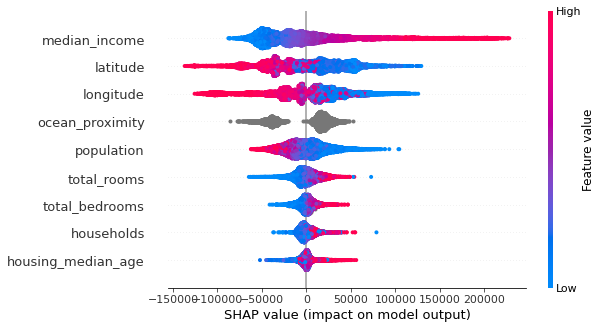

In [59]:
shap.summary_plot(shap_values, housing)

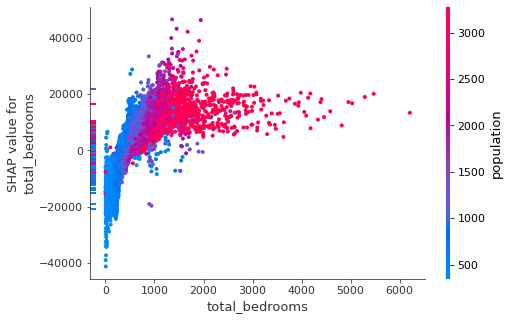

In [66]:
shap.dependence_plot('total_bedrooms', shap_values, housing)

In [94]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=housing.columns)
    return model.predict(data_asframe)
shap_kernel_explainer = shap.KernelExplainer(model_predict, housing)
shap_values_single = shap_kernel_explainer.shap_values(housing.iloc[0,:])


Using 16512 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


TypeError: ignored

In [98]:
shap.dependence_plot('total_bedrooms', shap_values_single, housing)

TypeError: ignored

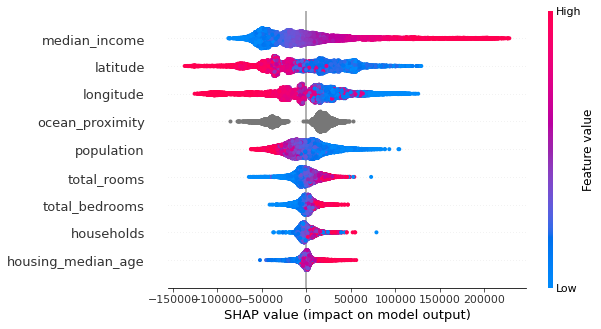

In [96]:
shap.summary_plot(shap_values,housing)

In [97]:
model

Pipeline(memory=None,
         steps=[('full',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                     

In [77]:
model